# 🛰️ Project: SAR Ship Detection with Computer Vision
**Author:** Engineering Candidate
**Tech Stack:** Python, OpenCV, NumPy, Matplotlib.

## 🎯 Objective
To automate the detection of maritime vessels in Synthetic Aperture Radar (SAR) imagery. Unlike optical satellites, SAR operates day and night and through cloud cover, making it crucial for maritime security and traffic monitoring.

## 🧠 Methodology
1.  **Data Ingestion:** Loading processed SAR image chips (Kaggle Dataset).
2.  **Preprocessing:** Gaussian filtering to reduce speckle noise inherent to radar data.
3.  **Segmentation:** Adaptive thresholding to separate high-backscatter targets (ships) from the clutter (sea).
4.  **Object Detection:** Contour analysis and bounding box generation.

### 1. Environment Setup & Data Ingestion
We initialize the environment, mount Google Drive to access the dataset, and load the target image in grayscale mode for intensity analysis.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Successfully loaded statek1.jpg with shape (640, 640)


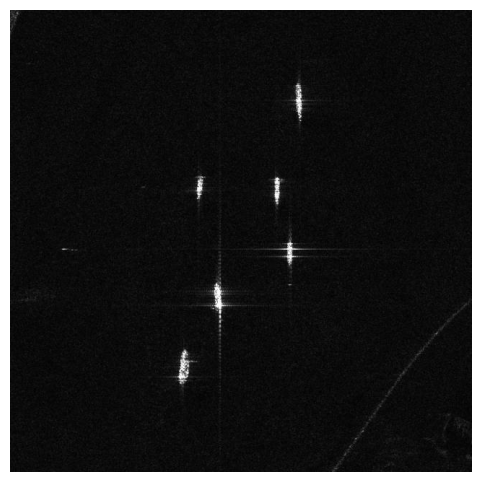

In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')

filename = 'statek1.jpg'
file_path = f'/content/drive/MyDrive/SpaceProject/{filename}'

image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

if image is None:
    print(f"Error: Could not load {filename}")
else:
    print(f"Successfully loaded {filename} with shape {image.shape}")

    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

### 2. Noise Reduction
Synthetic Aperture Radar (SAR) imagery typically contains speckle noise. We apply a Gaussian Blur kernel to smooth the image while preserving the structural integrity of large objects.

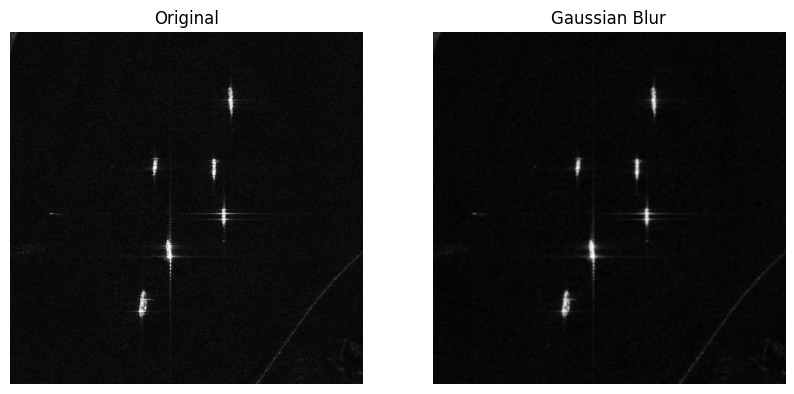

In [33]:
blurred_image = cv2.GaussianBlur(image, (5, 5), 0)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(blurred_image, cmap='gray')
ax[1].set_title('Gaussian Blur')
ax[1].axis('off')
plt.show()

### 3. Orientation Analysis & Pose Estimation
We apply adaptive thresholding and morphological dilation to segment the vessels. Using the Minimum Area Rectangle method (`minAreaRect`), we calculate the orientation angle and fit a rotated bounding box for each detected ship to estimate its heading.

Analysis Complete. Detected Ships: 6


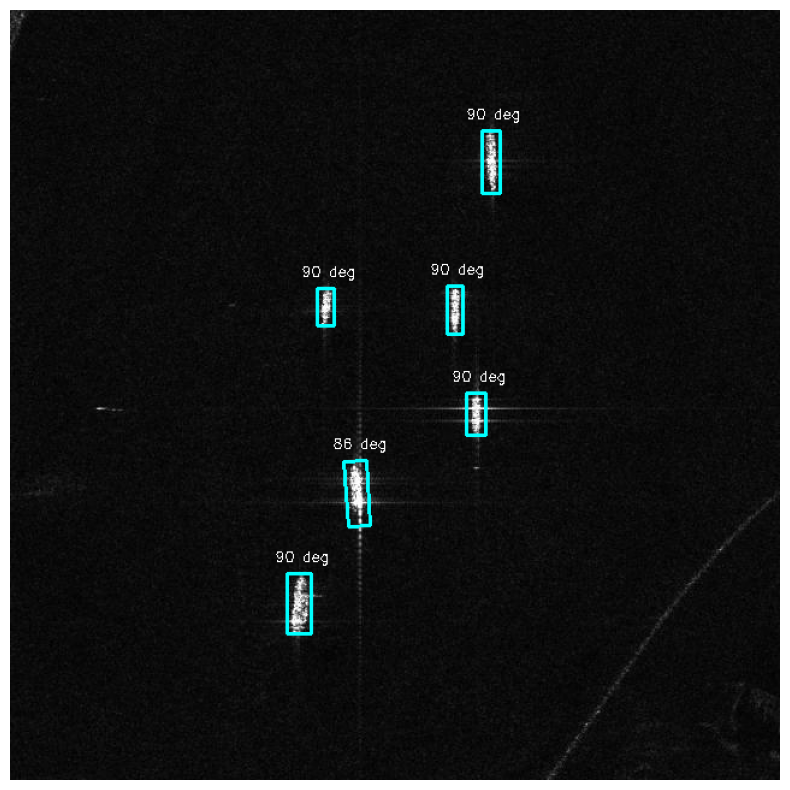

In [34]:
THRESHOLD_VALUE = 160
_, binary_mask = cv2.threshold(blurred_image, THRESHOLD_VALUE, 255, cv2.THRESH_BINARY)

kernel = np.ones((5, 5), np.uint8)
dilated_mask = cv2.dilate(binary_mask, kernel, iterations=2)

contours, _ = cv2.findContours(dilated_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
detected_count = 0

for contour in contours:
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)
    box = np.int64(box)

    width = rect[1][0]
    height = rect[1][1]

    if width > 10 and height > 10:
        cv2.drawContours(output_image, [box], 0, (0, 255, 255), 2)

        angle = int(rect[2])

        # Smart Text Positioning
        # Find the highest point of the box (smallest Y value)
        highest_y = np.min(box[:, 1])
        center_x = int(rect[0][0])

        text_position = (center_x - 20, highest_y - 10)

        cv2.putText(output_image, f"{angle} deg", text_position,
                    cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)
        detected_count += 1

print(f"Analysis Complete. Detected Ships: {detected_count}")

plt.figure(figsize=(10, 10))
plt.imshow(output_image)
plt.axis('off')
plt.show()

### 4. Intelligence Gathering: Size Estimation & Reporting
We simulate real-world analysis by calibrating the Ground Sample Distance (GSD) to 2.5 meters/pixel to estimate physical vessel dimensions.
The system classifies targets into three categories:
* **Small (Green):** < 80m
* **Medium (Yellow):** 80m - 120m
* **Large (Red):** > 120m

Finally, all tactical data (Position, Heading, Length, Class) is exported to a CSV file (`mission_report.csv`) for database integration.

Analysis Complete. Processed 6 targets.


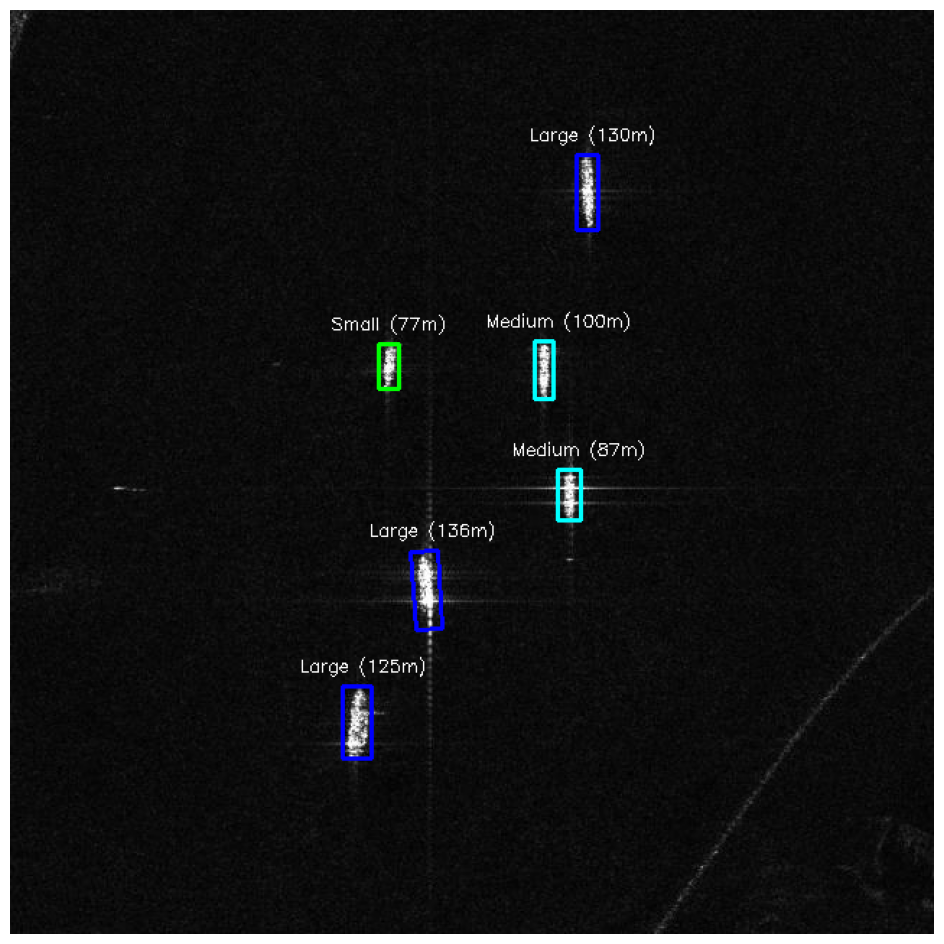


--- MISSION REPORT ---
   ID  Length_m  Heading_deg Category  GSD_Factor
0   0    125.00           90    Large         2.5
1   1    136.76           86    Large         2.5
2   2     87.50           90   Medium         2.5
3   3     77.50           90    Small         2.5
4   4    100.00           90   Medium         2.5
5   5    130.00           90    Large         2.5


In [35]:
import pandas as pd

THRESHOLD_VALUE = 160
GSD = 2.5

_, binary_mask = cv2.threshold(blurred_image, THRESHOLD_VALUE, 255, cv2.THRESH_BINARY)
kernel = np.ones((5, 5), np.uint8)
dilated_mask = cv2.dilate(binary_mask, kernel, iterations=2)
contours, _ = cv2.findContours(dilated_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
ship_database = []

for i, contour in enumerate(contours):
    rect = cv2.minAreaRect(contour)
    box = np.int64(cv2.boxPoints(rect))

    width_px = rect[1][0]
    height_px = rect[1][1]
    length_px = max(width_px, height_px)
    length_m = length_px * GSD
    angle = int(rect[2])

    if length_px > 10:
        if length_m < 80:
            category = "Small"
            color = (0, 255, 0)
        elif length_m < 120:
            category = "Medium"
            color = (0, 255, 255)
        else:
            category = "Large"
            color = (0, 0, 255)

        cv2.drawContours(output_image, [box], 0, color, 2)

        highest_y = np.min(box[:, 1])
        center_x = int(rect[0][0])
        label = f"{category} ({int(length_m)}m)"

        cv2.putText(output_image, label, (center_x - 40, highest_y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)

        ship_database.append({
            "ID": i,
            "Length_m": round(length_m, 2),
            "Heading_deg": angle,
            "Category": category,
            "GSD_Factor": GSD
        })

print(f"Analysis Complete. Processed {len(ship_database)} targets.")

plt.figure(figsize=(12, 12))
plt.imshow(output_image)
plt.axis('off')
plt.show()

df = pd.DataFrame(ship_database)
print("\n--- MISSION REPORT ---")
print(df)
df.to_csv('mission_report.csv', index=False)